
# Sleep staging on the Sleep Physionet dataset using Chambon2018 network

This tutorial shows how to train and test a sleep staging neural network with
Braindecode. We adapt the time distributed approach of [1]_ to learn on
sequences of EEG windows using the openly accessible Sleep Physionet dataset
[2]_ [3]_.


In [ ]:
# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)

## Loading and preprocessing the dataset

### Loading

First, we load the data using the
:class:`braindecode.datasets.sleep_physionet.SleepPhysionet` class. We load
two recordings from two different individuals: we will use the first one to
train our network and the second one to evaluate performance (as in the `MNE`_
sleep staging example).





In [1]:
from numbers import Integral
from braindecode.datasets import SleepPhysionet

subject_ids = [1, 2]
dataset = SleepPhysionet(
    subject_ids=subject_ids, recording_ids=[2], crop_wake_mins=30)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


Extracting EDF parameters from C:\Users\mengz\Box\Hoffman_Lab\HyperBCI\METHODS\HypernetBCI\data\physionet-sleep-data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


Extracting EDF parameters from C:\Users\mengz\Box\Hoffman_Lab\HyperBCI\METHODS\HypernetBCI\data\physionet-sleep-data\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Preprocessing

Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter. We omit the downsampling step of [1]_ as the Sleep
Physionet data is already sampled at a lower 100 Hz.



In [2]:
from braindecode.preprocessing import preprocess, Preprocessor
from numpy import multiply

high_cut_hz = 30
factor = 1e6

preprocessors = [
    Preprocessor(lambda data: multiply(data, factor), apply_on_array=True),  # Convert from V to uV
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz)
]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 3447000  =      0.000 ... 34470.000 secs...


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Reading 0 ... 3027000  =      0.000 ... 30270.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



### Extract windows

We extract 30-s windows to be used in the classification task.



In [3]:
from braindecode.preprocessing import create_windows_from_events

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload=True,
    mapping=mapping
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### Window preprocessing

We also preprocess the windows by applying channel-wise z-score normalization
in each window.



In [4]:
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

In [34]:
import numpy as np
from braindecode.samplers import SequenceSampler
from sklearn.utils import compute_class_weight

In [27]:
from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset

def get_subset(input_set, target_trial_num, random_sample=False, from_back=False):
    # check inputs
    assert isinstance(input_set, BaseConcatDataset)
    assert isinstance(target_trial_num, int)
    
    new_ds_lst = []

    if random_sample:
        return None
        # base_ds_cnt = len(input_set.datasets)

        # if base_ds_cnt == 1:
        #     cur_ds = input_set.datasets[0]
        #     trial_idx = generate_non_repeating_integers(target_trial_num, len(cur_ds))
        #     # print(trial_idx[:4])
        #     new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
        #                                                 description=cur_ds.description))

        # elif base_ds_cnt > 1:
        #     trial_cnt_from_each_base_ds = sample_integers_sum_to_x(target_trial_num, base_ds_cnt)
        #     for i, cnt in enumerate(trial_cnt_from_each_base_ds):
        #         if not cnt:
        #             # no sampling in current base dataset
        #             continue
            
        #         # Access current base dataset
        #         cur_ds = input_set.datasets[i]
        #         assert isinstance(cur_ds, EEGWindowsDataset)
        #         # Randomly sample trial index
        #         try:
        #             trial_idx = generate_non_repeating_integers(cnt, len(cur_ds))
        #             new_ds_lst.append(EEGWindowsDataset(cur_ds.raw, cur_ds.metadata.iloc[trial_idx], 
        #                                                 description=cur_ds.description))
        #         except ValueError:
        #             # If trying to sample more trials in current ds than there are
        #             # Get entire cur_ds, and get what's missing fromt the next ds
        #             new_ds_lst.append(cur_ds)
        #             trial_cnt_from_each_base_ds[i+1] += (cnt - len(cur_ds))

    else:
    
        if from_back:
            for ds in reversed(input_set.datasets):
                assert isinstance(ds, EEGWindowsDataset)
                if target_trial_num > cur_run_trial_num:
                    new_ds_lst.append(ds)
                    target_trial_num -= cur_run_trial_num
                else:
                    new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[-target_trial_num:], description=ds.description))
                    break

        else:
            for ds in input_set.datasets:
                assert isinstance(ds, EEGWindowsDataset)
                cur_run_trial_num = len(ds.metadata)
                if target_trial_num > cur_run_trial_num:
                    new_ds_lst.append(ds)
                    target_trial_num -= cur_run_trial_num
                else:
                    new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description))
                    break

    return BaseConcatDataset(new_ds_lst)

In [40]:
def get_center_label(x):
    # Use label of center window in the sequence as sequence target
    if isinstance(x, Integral):
        return x
    return x[np.ceil(len(x) / 2).astype(int)] if len(x) > 1 else x

In [37]:
# Sequences of 3 consecutive windows
n_windows = 3 
# Maximally overlapping sequences
n_windows_stride = 2

for subject_id, subject_dataset in windows_dataset.split('subject').items():

    print(f'Subject {subject_id}')

    test_percentage = 0.2
    test_set_size = int(len(subject_dataset) * test_percentage)
    train_set = get_subset(subject_dataset, target_trial_num=len(subject_dataset)-test_set_size)
    test_set = get_subset(subject_dataset, target_trial_num=test_set_size, from_back=True)

    # display(train_set.get_metadata())
    # display(test_set.get_metadata())

    test_sampler = SequenceSampler(
        test_set.get_metadata(), n_windows, n_windows_stride, randomize=True
    )
    test_set.target_transform = get_center_label

    train_set_size = len(train_set)
    data_amount_step = 40
    for training_data_amount in np.arange(1, (train_set_size // data_amount_step) + 1) * data_amount_step:

        # random_sample should be True
        train_subset = get_subset(train_set, target_trial_num=int(training_data_amount))
        train_sampler = SequenceSampler(
            train_subset.get_metadata(), n_windows, n_windows_stride, randomize=True
        )
        train_subset.target_transform = get_center_label

        y_train = [train_subset[idx][1] for idx in train_sampler]
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

        print(f'Currently training for subject {subject_id} with {training_data_amount}={len(train_sampler)}={len(y_train)} sequences')

Subject 1
Currently training for subject 1 with 40=19=19 sequences
Currently training for subject 1 with 80=39=39 sequences
Currently training for subject 1 with 120=59=59 sequences
Currently training for subject 1 with 160=79=79 sequences
Currently training for subject 1 with 200=99=99 sequences
Currently training for subject 1 with 240=119=119 sequences
Currently training for subject 1 with 280=139=139 sequences
Currently training for subject 1 with 320=159=159 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 1 with 360=179=179 sequences
Currently training for subject 1 with 400=199=199 sequences
Currently training for subject 1 with 440=219=219 sequences
Currently training for subject 1 with 480=239=239 sequences
Currently training for subject 1 with 520=259=259 sequences
Currently training for subject 1 with 560=279=279 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 1 with 600=299=299 sequences
Currently training for subject 1 with 640=319=319 sequences
Currently training for subject 1 with 680=339=339 sequences
Currently training for subject 1 with 720=359=359 sequences
Currently training for subject 1 with 760=379=379 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 1 with 800=399=399 sequences
Currently training for subject 1 with 840=419=419 sequences
Currently training for subject 1 with 880=439=439 sequences
Currently training for subject 1 with 920=459=459 sequences
Subject 2


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 2 with 40=19=19 sequences
Currently training for subject 2 with 80=39=39 sequences
Currently training for subject 2 with 120=59=59 sequences
Currently training for subject 2 with 160=79=79 sequences
Currently training for subject 2 with 200=99=99 sequences
Currently training for subject 2 with 240=119=119 sequences
Currently training for subject 2 with 280=139=139 sequences
Currently training for subject 2 with 320=159=159 sequences
Currently training for subject 2 with 360=179=179 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 2 with 400=199=199 sequences
Currently training for subject 2 with 440=219=219 sequences
Currently training for subject 2 with 480=239=239 sequences
Currently training for subject 2 with 520=259=259 sequences
Currently training for subject 2 with 560=279=279 sequences
Currently training for subject 2 with 600=299=299 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 2 with 640=319=319 sequences
Currently training for subject 2 with 680=339=339 sequences
Currently training for subject 2 with 720=359=359 sequences
Currently training for subject 2 with 760=379=379 sequences


c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = v
c:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\datasets\base.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Currently training for subject 2 with 800=399=399 sequences


## Create model

We can now create the deep learning model. In this tutorial, we use the sleep
staging architecture introduced in [1]_, which is a four-layer convolutional
neural network. We use the time distributed version of the model, where the
feature vectors of a sequence of windows are concatenated and passed to a
linear layer for classification.




In [20]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018, TimeDistributed

cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=31, cuda=cuda)

n_classes = 5
# Extract number of channels and time steps from dataset
n_channels, input_size_samples = train_set[0][0].shape

feat_extractor = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_outputs=n_classes,
    n_times=input_size_samples,
    return_feats=True
)

model = nn.Sequential(
    TimeDistributed(feat_extractor),  # apply model on each 30-s window
    nn.Sequential(  # apply linear layer on concatenated feature vectors
        nn.Flatten(start_dim=1),
        nn.Dropout(0.5),
        nn.Linear(feat_extractor.len_last_layer * n_windows, n_classes)
    )
)

# Send model to GPU
if cuda:
    model.cuda()

## Training

We can now train our network. :class:`braindecode.EEGClassifier` is a
braindecode object that is responsible for managing the training of neural
networks. It inherits from :class:`skorch.NeuralNetClassifier`, so the
training logic is the same as in
[Skorch](https://skorch.readthedocs.io/en/stable/)_.

<div class="alert alert-info"><h4>Note</h4><p>We use different hyperparameters from [1]_, as these hyperparameters were
   optimized on a different dataset (MASS SS3) and with a different number of
   recordings. Generally speaking, it is recommended to perform
   hyperparameter optimization if reusing this code on a different dataset or
   with more recordings.</p></div>




In [21]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 32
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    classes=np.unique(y_train),
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.1798        1.5856       0.1220           0.2000        1.5893  1.7596
      2           0.2434        1.5177       0.1964           0.3358        1.5321  1.5729
      3           0.2945        1.4009       0.2054           0.3508        1.5213  1.5638
      4           0.4086        1.3395       0.3006           0.4185        1.4261  1.7018
      5           0.4399        1.2244       0.4018           0.4728        1.3719  1.9333
      6           0.5144        1.1301       0.4405           0.4903        1.2758  1.6669
      7           0.5610        1.0355       0.5833           0.5167        1.2839  1.6681
      8           0.6515        0.9343       0.6577           0.6779        1.0782  1.6855
      9           0.6875        0.7856       0.5089           0.6460        0.9789  1.6964

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): TimeDistributed(
      (module): SleepStagerChambon2018(
        (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
        (feature_extractor): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
          (1): Identity()
          (2): ReLU()
          (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
          (5): Identity()
          (6): ReLU()
          (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=816, out_features=5, bias=True)
    )
  ),
)

## Plot results

We use the history stored by Skorch during training to plot the performance of
the model throughout training. Specifically, we plot the loss and the balanced
balanced accuracy for the training and validation sets.



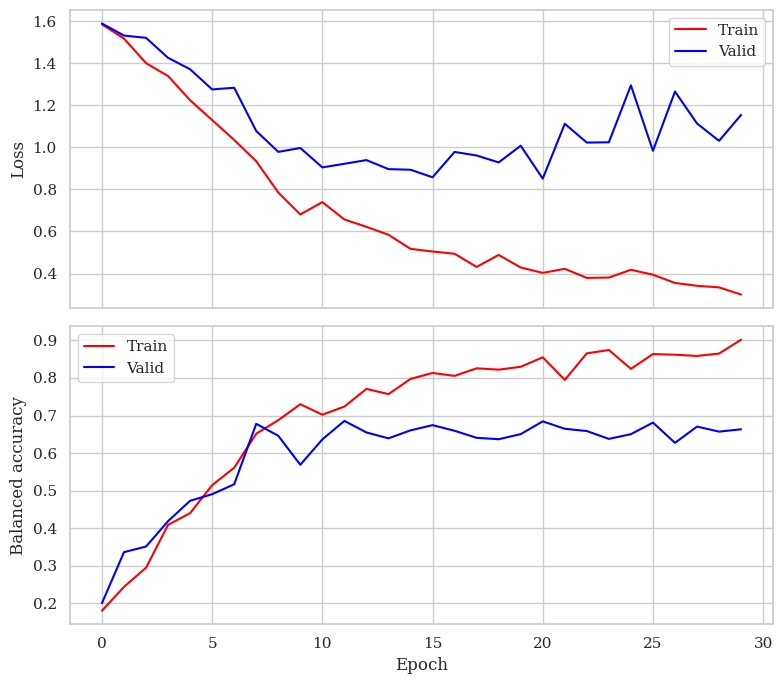

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())
df.index.name = "Epoch"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
df[['train_loss', 'valid_loss']].plot(color=['r', 'b'], ax=ax1)
df[['train_bal_acc', 'valid_bal_acc']].plot(color=['r', 'b'], ax=ax2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Balanced accuracy')
ax1.legend(['Train', 'Valid'])
ax2.legend(['Train', 'Valid'])
fig.tight_layout()
plt.show()

Finally, we also display the confusion matrix and classification report:




In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from braindecode.visualization import plot_confusion_matrix

y_true = [valid_set[[i]][1][0] for i in range(len(valid_sampler))]
y_pred = clf.predict(valid_set)

confusion_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(confusion_mat=confusion_mat,
                      class_names=['Wake', 'N1', 'N2', 'N3', 'REM'])

print(classification_report(y_true, y_pred))

Finally, we can also visualize the hypnogram of the recording we used for
validation, with the predicted sleep stages overlaid on top of the true
sleep stages. We can see that the model cannot correctly identify the
different sleep stages with this amount of training.



In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_true, color='b', label='Expert annotations')
ax.plot(y_pred.flatten(), color='r', label='Predict annotations', alpha=0.5)
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Sleep stage')

Our model was able to learn despite the low amount of data that was available
(only two recordings in this example) and reached a balanced accuracy of
about 36% in a 5-class classification task (chance-level = 20%) on held-out
data.

<div class="alert alert-info"><h4>Note</h4><p>To further improve performance, more recordings should be included in the
   training set, and hyperparameters should be selected accordingly.
   Increasing the sequence length was also shown in [1]_ to help improve
   performance, especially when few EEG channels are available.</p></div>



## References

.. [1] Chambon, S., Galtier, M., Arnal, P., Wainrib, G. and Gramfort, A.
      (2018)A Deep Learning Architecture for Temporal Sleep Stage
      Classification Using Multivariate and Multimodal Time Series.
      IEEE Trans. on Neural Systems and Rehabilitation Engineering 26:
      (758-769)

.. [2] B Kemp, AH Zwinderman, B Tuk, HAC Kamphuisen, JJL Oberyé. Analysis of
       a sleep-dependent neuronal feedback loop: the slow-wave
       microcontinuity of the EEG. IEEE-BME 47(9):1185-1194 (2000).

.. [3] Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh,
       Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000)
       PhysioBank, PhysioToolkit, and PhysioNet: Components of a New
       Research Resource for Complex Physiologic Signals.
       Circulation 101(23):e215-e220

